# Example of NetworkProcesses

In this notebook, we create an SIR process using the `NetworkProcesses` library. We will analyse four techniques including: degree based heterogeneous mean field theory using either an RK4 integrator (`HMF`) or through stochastic integration (`STO`), percolation using (`PERCOLATION`) and generating functions using (`GFs`). 

## Generating functions 

From (Newman, 2002), we define two generating functions, $G_0(u,T)$ and $G_1(u,T)$ for a configuration model network as:

$$
\begin{align}
&G_0(u,T) = \sum^\infty_{k=0} p_k ( 1- T+uT)^k\\
&G_1(u,T) = \frac{1}{\langle k\rangle} \sum^\infty_{k=0} k p _k ( 1-T+uT)^{k-1}
\end{align}
$$

where $T$ is the disease transmissibility, $p_k$ is the degree distribution and $u$, the probability of not belonging to the giant component, is the solution to the self-consistent equation:

$$
u_{\text{new}}  = G_1(u_{\text{old}} ,T)
$$

after iteration, $u$ should converge to $u_0<1$ and we have that:

$$
u_{\text{new}} \approx u_{\text{old}} = u _0
$$

This value can then be used to solve:

$$
G_0(u_0,T)
$$

which can then be used to find the fraction of the network that is occupied, $\mathcal A(T)$, as a function of the transmissibility:

$$
\mathcal A(T) = 1 - G_0(u_0,T)
$$


## Degree based heterogeneous mean field  

The degree based heterogenous mean field SIR model (Pastor-Satorras & Vespignani, 2001) under the degree block approximation is:

$$
\begin{align}
\frac{ds_k(t)}{dt} &= - \beta k[1 - i_k(t) - r_k(t)] \Theta _k(t)\\
\frac{di_k(t)}{dt} &= \beta k[1 - i_k(t) - r_k(t)] \Theta _k(t) - \gamma i_k(t)\\
\frac{dr_k(t)}{dt} &=  \gamma i_k(t)
\end{align}
$$

where $\Theta_k(t)$ is the probability of having an infected neighbour of degree $k$: 

\begin{equation}
\Theta(t) = \frac{1}{\langle k \rangle } \sum_{k'=0}^\infty (k'-1) p_{k'}(k') i_{k'}(t)
\end{equation}

where $\langle k \rangle =\sum_{k'} k'p_{k'}(k')$. This can be directly integrated using a 4th-order Runge-Kutta integrator as we do in `HMF`. 

We can reformulate this into a discrete event-based model using the following two events:


| **Event/Reaction**            | **Probability/Propensity**          |
|-------------------------    |-----------------------|
| $S_k \rightarrow I_k$ | $k\beta S_k\Theta_k$  |
| $I_k\rightarrow R_k$ | $\gamma I_k$          |

This system can be integrated using Gillespie stochastic simulation as we do in `STO`. We begin by importing the required libraries and then setup and run each experiment before plotting them to compare the results.




In [1]:
import epyc
import network_processes
import numpy as np

# for figures in notebook
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

## Disease parameters setup

In [2]:
# disease parameters
T = np.linspace(0.01, 0.99, 25)
gamma = 0.1
beta = (T * gamma + 0.0 ) / ( 1 - T )
pInfected = 0.02 

# network parameters 
N = 5000
kmean = 5

## Network Generating function model using `GFs`

In [3]:
# create a Lab instance for simulation
lab = epyc.Lab()

# set parameters for the model
lab[network_processes.GFs.N] = N
lab[network_processes.GFs.AVERAGE_K] = kmean
lab[network_processes.GFs.T] = T

# instance class
e = network_processes.GFs()

# repetitions at each point in the parameter space
repetitions = 1

# run the experiment
sto = lab.runExperiment(epyc.RepeatedExperiment(e, repetitions))

# extract results
results = lab.results()

# create a dataframe 
ef = lab.notebook().dataframe()

## Network HMF using `HMF` (RK4)

In [4]:
# create a Lab instance for simulation
lab = epyc.Lab()

# set parameters for the model
lab['pInfected'] = pInfected
lab['pRecover'] = gamma
lab['pInfect'] = beta

lab[network_processes.HMF.N] = N
lab[network_processes.HMF.AVERAGE_K] = kmean

# instance class
e = network_processes.HMF()

# repetitions at each point in the parameter space
repetitions = 1

# run the experiment
sto = lab.runExperiment(epyc.RepeatedExperiment(e, repetitions))

# extract results
results = lab.results()

# create a dataframe 
ff = lab.notebook().dataframe()

## Network HMF using STO (stochastic integration)

In [5]:
# create a Lab instance for simulation
lab = epyc.Lab()

# set parameters for the model
lab['pInfected'] = pInfected
lab['pRecover'] = gamma
lab['pInfect'] = beta
lab[network_processes.STO.N] = N
lab[network_processes.STO.AVERAGE_K] = kmean

# instance class
e = network_processes.STO()

# repetitions at each point in the parameter space
repetitions = 1

# run the experiment
sto = lab.runExperiment(epyc.RepeatedExperiment(e, repetitions))

# extract results
results = lab.results()

# create a dataframe 
gf = lab.notebook().dataframe()

## Percolation using `PERCOLATION`

In [6]:
# create a Lab instance for simulation
lab = epyc.Lab()

# set parameters for the model
lab[network_processes.PERCOLATION.T] = T
lab[network_processes.PERCOLATION.N] = N
lab[network_processes.PERCOLATION.AVERAGE_K] = kmean

# instance class
e = network_processes.PERCOLATION()

# repetitions at each point in the parameter space
repetitions = 1

# run the experiment
sto = lab.runExperiment(epyc.RepeatedExperiment(e, repetitions))

# extract results
results = lab.results()

# create a dataframe 
hf = lab.notebook().dataframe()

## Plot the results!

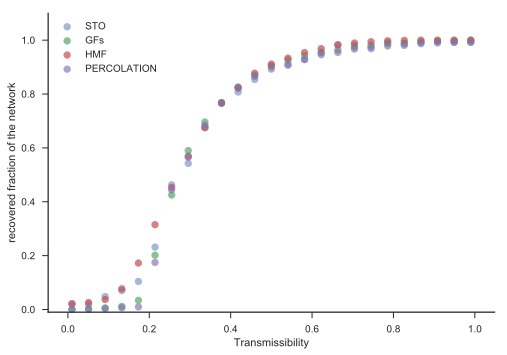

In [7]:
from operator import itemgetter # for unpacking STO data

seaborn.set_style("white") # style 
seaborn.set_style("ticks") # style 

# plot HMF STO data (gf) 
plt.scatter(gf['pInfect']/(gf['pInfect'] + gf['pRecover']),(list(map(itemgetter(2), gf['final_state']))/gf['N']),label ='STO', alpha = 0.5)

# plot GF data (ef)
plt.scatter(ef['T'], ef['S_1'], alpha = 0.7, label='GFs')

# plot HMF RK4 data (ff)
plt.scatter(ff['pInfect']/(ff['pInfect'] + ff['pRecover']), list(map(itemgetter(2), ff['final_state'])), alpha = 0.7, label ='HMF')

# plot the percolation (hf)
plt.scatter(hf['T'], hf['occupied_fraction'], alpha = 0.65, label='PERCOLATION')

seaborn.despine() # remove verticle and right hand axes
axes = plt.gca()
axes.set_ylim([-0.01,1.1]) # y-axis limits
plt.xlabel('Transmissibility')
plt.ylabel('recovered fraction of the network')
plt.legend()
#plt.savefig('four_classes.pdf', format='pdf')

The results of an SIR process on a random network using `HMF`, `STO` and `GFs` and `PERCOLATION`. It is clear that all the techniques are in close agreement; however, `STO`, being stochastic, can exhibit premature epidemic death if $N$ is small. Due to this, some results may fall short of the expected epidemic size.

## References

* Newman Phys. Rev. E **66**, 016128 2002

* Pastor-Satorras, R. and Vespignani, A. (2001). Epidemic dynamics and endemic states in complex networks. Physical Review E Statistical Nonlinear \& Soft Matter Physics, **63**(6 Pt 2), 066117.